<a href="https://colab.research.google.com/github/QuantLet/ATSSB-Applied-Time-Series-Solutions-Book/blob/main/ATSSB_VAR/ATSSB_VAR2_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 7.3: Three-dimensional VAR(2) Process

Estimated Φ₁:
[[ 0.751   0.0323 -0.0463]
 [ 0.0727  0.4342  0.1003]
 [ 0.9384 -0.0431  0.8131]]

True Φ₁:
[[0.7 0.1 0. ]
 [0.  0.4 0.1]
 [0.9 0.  0.8]]

Estimated Φ₂:
[[-0.183   0.0006  0.0596]
 [-0.0713  0.0201  0.1114]
 [ 0.038  -0.0309  0.02  ]]

True Φ₂:
[[-0.2  0.   0. ]
 [ 0.   0.1  0.1]
 [ 0.   0.   0. ]]

(5) GRANGER CAUSALITY TESTS

Granger Causality F-Tests:
----------------------------------------------------------------------
H0: Y does not Granger-cause X               F-stat      p-value     Result
----------------------------------------------------------------------
X2 → X1                                     0.200     0.8187    Cannot reject
X3 → X1                                     1.962     0.1417    Cannot reject
X1 → X2                                     4.827     0.0084***  REJECT H0
X3 → X2                                   174.646     0.0000***  REJECT H0
X1 → X3                                   115.551     0.0

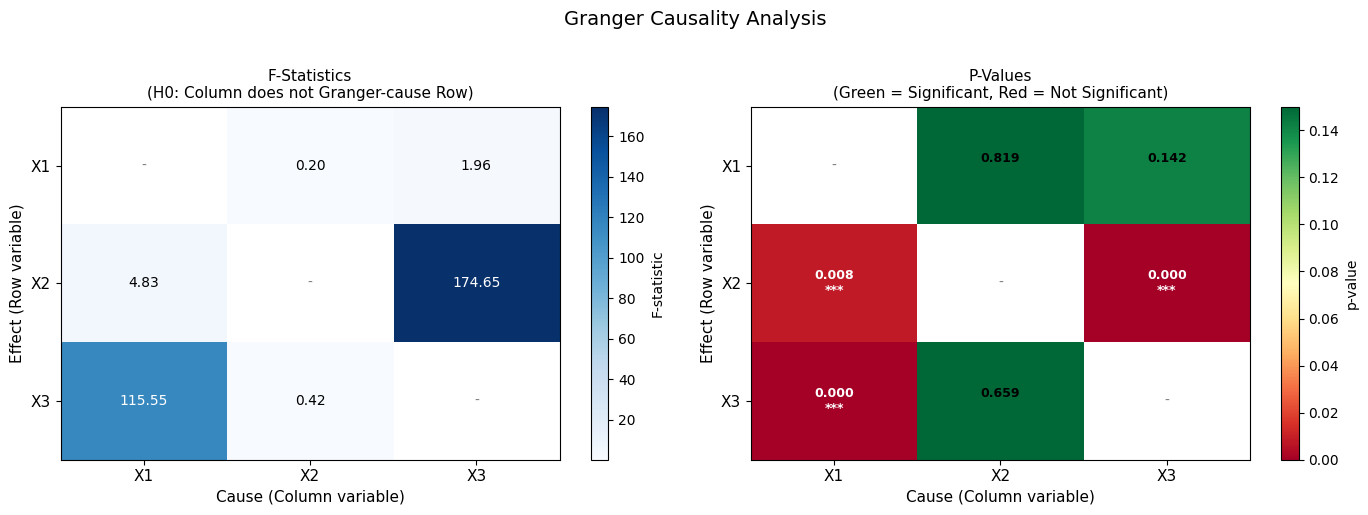


✓ Granger causality heatmap saved as 'granger_causality_heatmap.png'


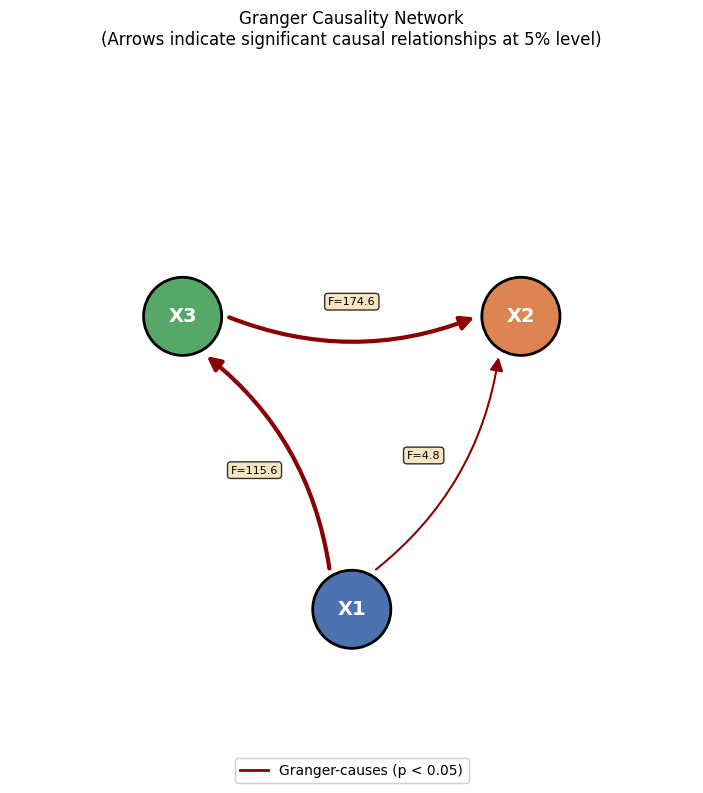

✓ Granger causality network saved as 'granger_causality_network.png'

Computing bootstrap confidence intervals for IRF...
Bootstrap complete!


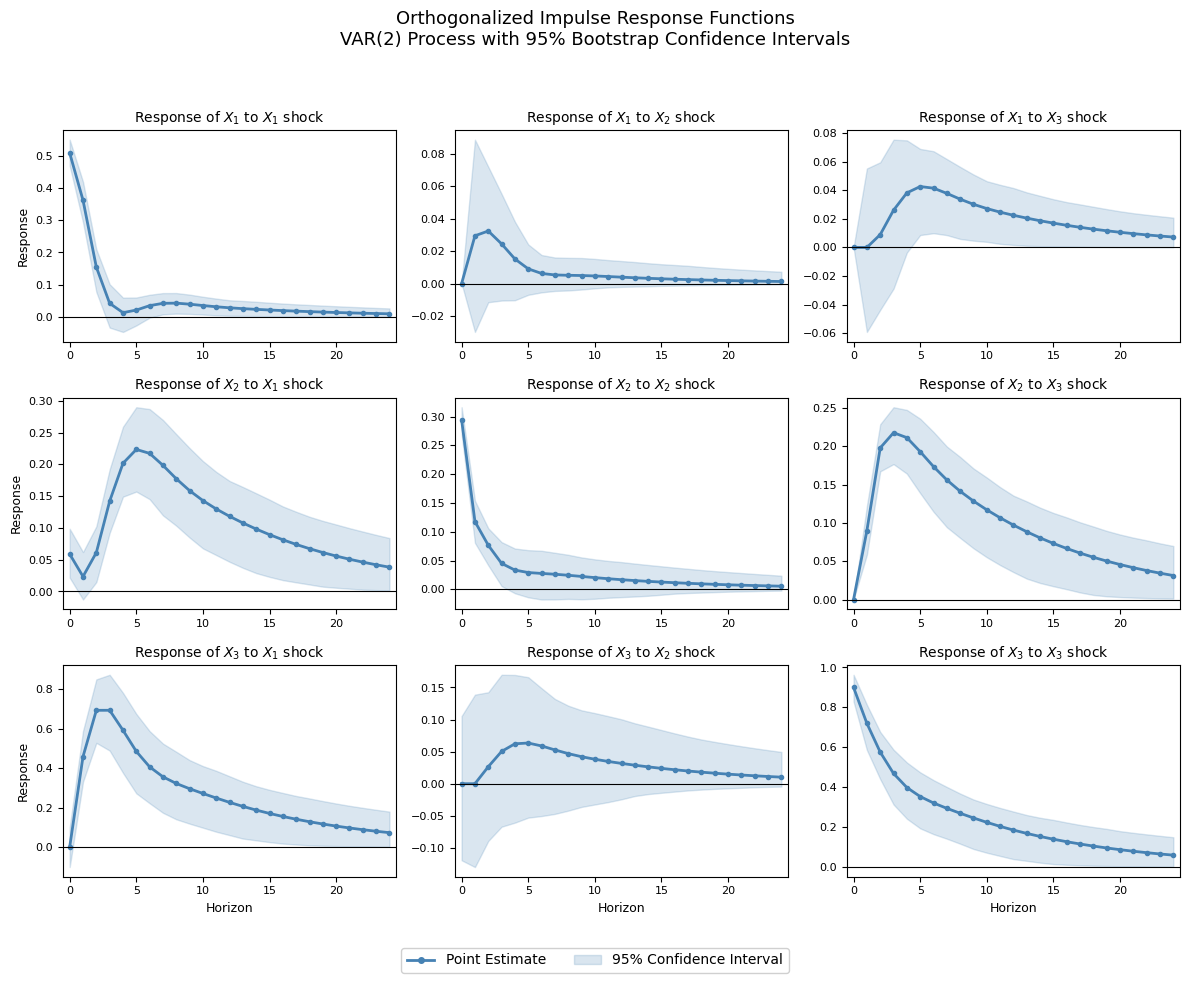


✓ Orthogonalized IRF plot saved as 'irf_var2_orthogonalized.png'


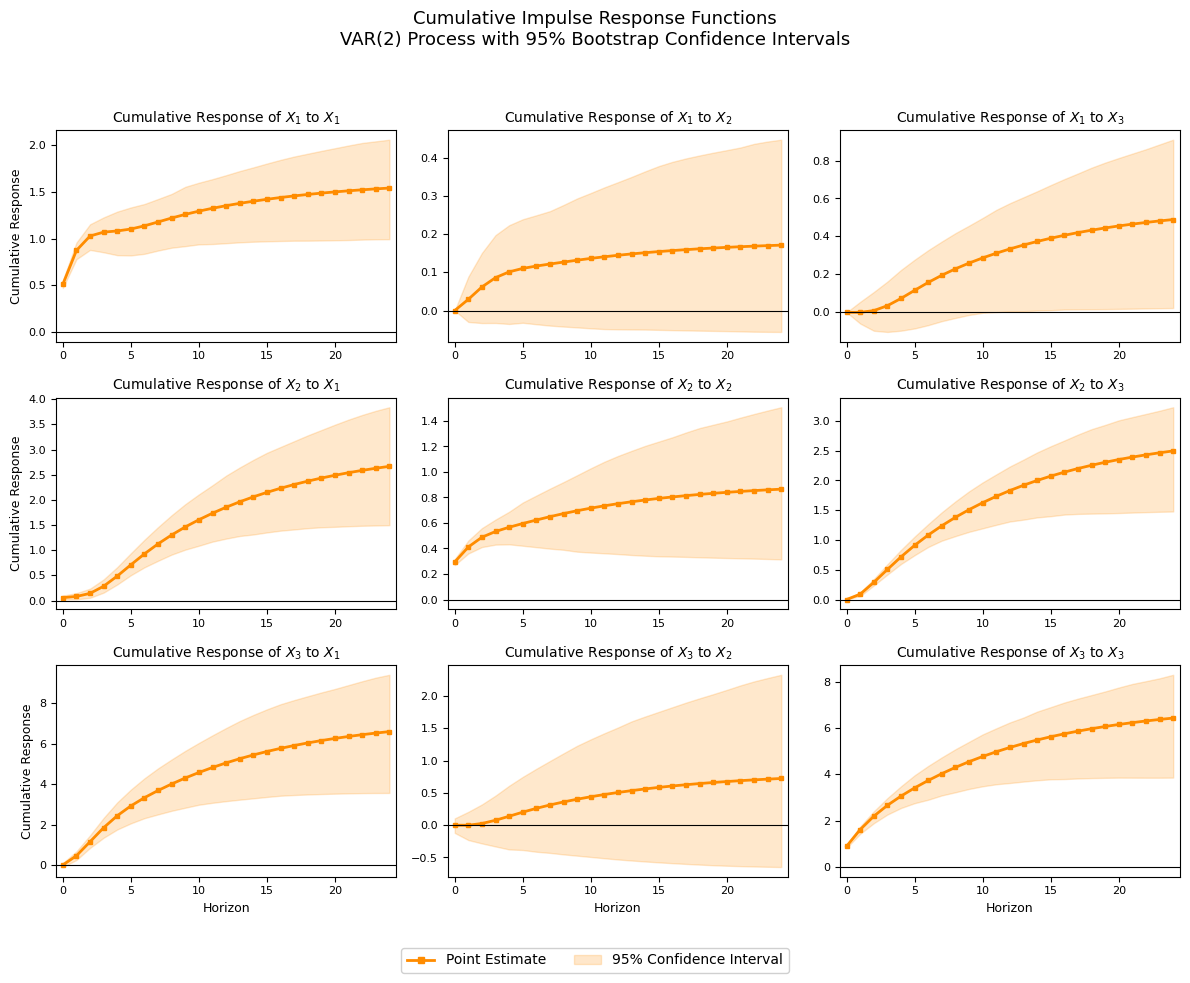

✓ Cumulative IRF plot saved as 'irf_var2_cumulative.png'


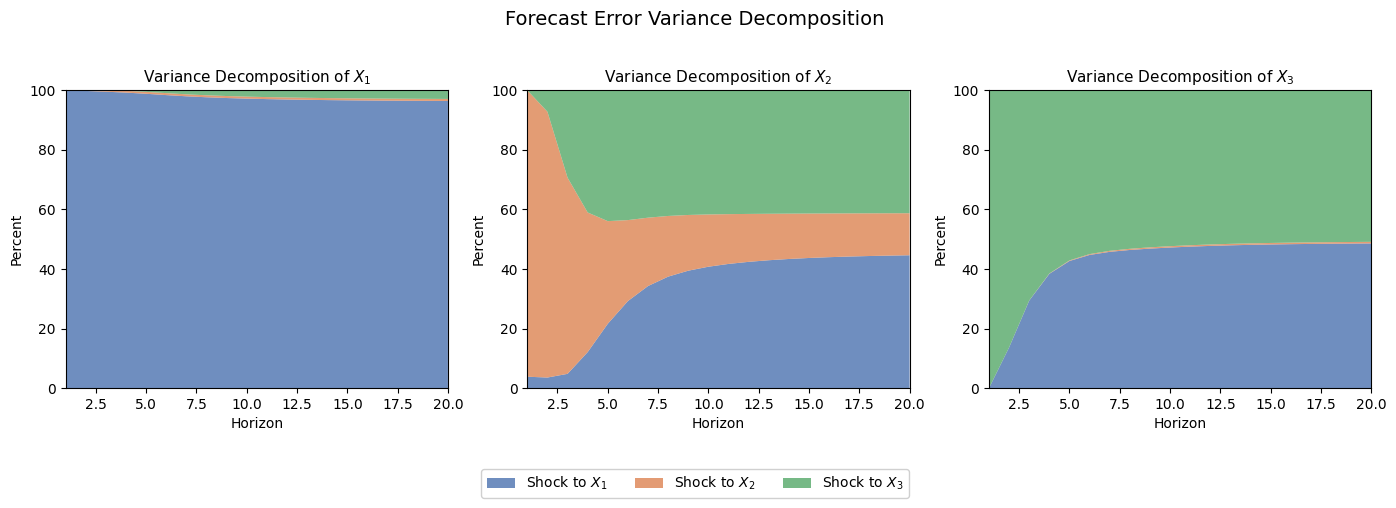

✓ FEVD plot saved as 'fevd_var2.png'


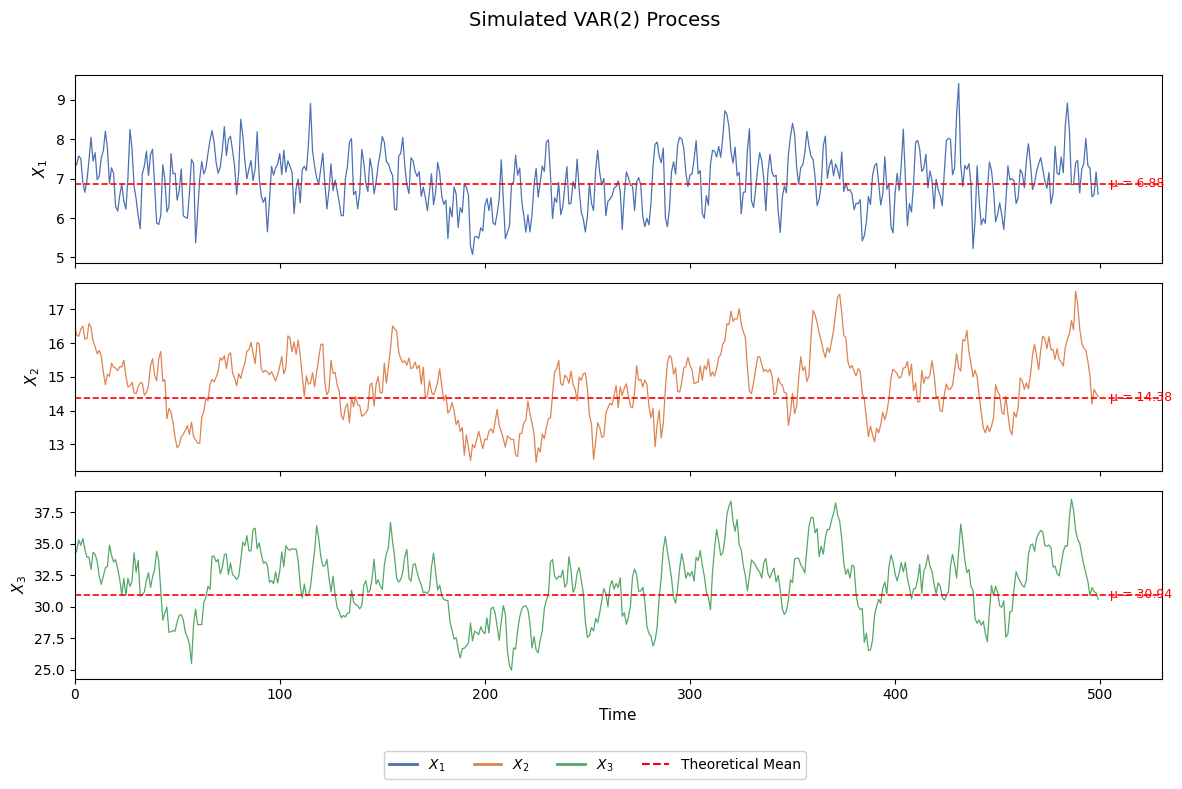

✓ Simulation plot saved as 'var2_simulation.png'

SUMMARY

Granger Causality Summary (5% significance level):
--------------------------------------------------
  ✗ X2 does NOT Granger-cause X1 (p = 0.8187)
  ✗ X3 does NOT Granger-cause X1 (p = 0.1417)
  ✓ X1 Granger-causes X2 (p = 0.0084)
  ✓ X3 Granger-causes X2 (p = 0.0000)
  ✓ X1 Granger-causes X3 (p = 0.0000)
  ✗ X2 does NOT Granger-cause X3 (p = 0.6595)

FEVD at horizon h=20 (%):
--------------------------------------------------
Variable  Shock X1       Shock X2       Shock X3       
X1                96.4%           0.7%           2.9%  
X2                44.6%          14.1%          41.3%  
X3                48.6%           0.5%          50.9%  

Analysis Complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats

# =============================================================================
# Exercise 7.3: Three-dimensional VAR(2) Process
# =============================================================================

# Define the model parameters
nu = np.array([2, 1, 0])  # Intercept vector

Phi1 = np.array([
    [0.7, 0.1, 0.0],
    [0.0, 0.4, 0.1],
    [0.9, 0.0, 0.8]
])

Phi2 = np.array([
    [-0.2, 0.0, 0.0],
    [0.0, 0.1, 0.1],
    [0.0, 0.0, 0.0]
])

Sigma = np.array([
    [0.26, 0.03, 0.0],
    [0.03, 0.09, 0.0],
    [0.0, 0.0, 0.81]
])

n = 3  # dimension
I3 = np.eye(n)
var_names = ['$X_1$', '$X_2$', '$X_3$']
var_names_plain = ['X1', 'X2', 'X3']

# =============================================================================
# Compute mean vector
# =============================================================================
I_minus_Phi = I3 - Phi1 - Phi2
I_minus_Phi_inv = linalg.inv(I_minus_Phi)
mu = I_minus_Phi_inv @ nu

# =============================================================================
# Simulate VAR(2) process for estimation
# =============================================================================
np.random.seed(42)
T = 500
burn_in = 100

epsilon = np.random.multivariate_normal(np.zeros(n), Sigma, T + burn_in)

X = np.zeros((T + burn_in, n))
X[0] = mu
X[1] = mu

for t in range(2, T + burn_in):
    X[t] = nu + Phi1 @ X[t-1] + Phi2 @ X[t-2] + epsilon[t]

# Remove burn-in
X = X[burn_in:]

# =============================================================================
# Estimate VAR(2) by OLS
# =============================================================================
Y = X[2:]  # Dependent variable (T-2 x n)
X_lag1 = X[1:-1]  # First lag
X_lag2 = X[:-2]   # Second lag

# Design matrix: [1, X_{t-1}, X_{t-2}]
X_design = np.hstack([np.ones((len(Y), 1)), X_lag1, X_lag2])

# OLS estimation
beta_hat = linalg.lstsq(X_design, Y)[0]

# Extract estimated coefficients
nu_hat = beta_hat[0]
Phi1_hat = beta_hat[1:4].T
Phi2_hat = beta_hat[4:7].T

# Compute residuals
residuals = Y - X_design @ beta_hat
T_eff = len(Y)
k = X_design.shape[1]  # Number of regressors per equation

# Residual covariance matrix
Sigma_hat = (residuals.T @ residuals) / (T_eff - k)

print("=" * 70)
print("Exercise 7.3: Three-dimensional VAR(2) Process")
print("=" * 70)

print("\nEstimated Φ₁:")
print(np.round(Phi1_hat, 4))
print("\nTrue Φ₁:")
print(Phi1)

print("\nEstimated Φ₂:")
print(np.round(Phi2_hat, 4))
print("\nTrue Φ₂:")
print(Phi2)

# =============================================================================
# (5) Granger Causality Tests
# =============================================================================
print("\n" + "=" * 70)
print("(5) GRANGER CAUSALITY TESTS")
print("=" * 70)

def granger_causality_test(Y, X_design, restricted_cols, equation_idx, T_eff, k):
    """
    Perform Granger causality F-test.

    H0: coefficients on restricted_cols are jointly zero
    """
    # Unrestricted model
    beta_u = linalg.lstsq(X_design, Y[:, equation_idx])[0]
    resid_u = Y[:, equation_idx] - X_design @ beta_u
    RSS_u = np.sum(resid_u ** 2)

    # Restricted model (exclude columns)
    X_restricted = np.delete(X_design, restricted_cols, axis=1)
    beta_r = linalg.lstsq(X_restricted, Y[:, equation_idx])[0]
    resid_r = Y[:, equation_idx] - X_restricted @ beta_r
    RSS_r = np.sum(resid_r ** 2)

    # F-statistic
    q = len(restricted_cols)  # Number of restrictions
    df1 = q
    df2 = T_eff - k

    F_stat = ((RSS_r - RSS_u) / q) / (RSS_u / df2)
    p_value = 1 - stats.f.cdf(F_stat, df1, df2)

    return F_stat, p_value, df1, df2

print("\nGranger Causality F-Tests:")
print("-" * 70)
print(f"{'H0: Y does not Granger-cause X':<40} {'F-stat':>10} {'p-value':>12} {'Result':>10}")
print("-" * 70)

# Store results for visualization
granger_results = np.zeros((n, n))
granger_pvalues = np.zeros((n, n))

for i in range(n):  # Equation for X_i
    for j in range(n):  # Testing if X_j Granger-causes X_i
        if i != j:
            # Columns to restrict: lag 1 and lag 2 of variable j
            # Design matrix: [const, X1_{t-1}, X2_{t-1}, X3_{t-1}, X1_{t-2}, X2_{t-2}, X3_{t-2}]
            # Indices:        [0,     1,        2,        3,        4,        5,        6      ]
            restricted_cols = [1 + j, 4 + j]  # Lag 1 and Lag 2 of variable j

            F_stat, p_value, df1, df2 = granger_causality_test(
                Y, X_design, restricted_cols, i, T_eff, k
            )

            granger_results[i, j] = F_stat
            granger_pvalues[i, j] = p_value

            result = "REJECT H0" if p_value < 0.05 else "Cannot reject"
            symbol = "***" if p_value < 0.01 else ("**" if p_value < 0.05 else ("*" if p_value < 0.10 else ""))

            print(f"{var_names_plain[j]} → {var_names_plain[i]:<33} {F_stat:>10.3f} {p_value:>10.4f}{symbol:>3} {result:>10}")

print("-" * 70)
print("Significance: *** p<0.01, ** p<0.05, * p<0.10")

# Summary based on TRUE coefficients
print("\n" + "-" * 70)
print("Theoretical Granger Causality (based on true coefficients):")
print("-" * 70)

for i in range(n):
    for j in range(n):
        if i != j:
            coef1 = Phi1[i, j]
            coef2 = Phi2[i, j]
            causes = (coef1 != 0) or (coef2 != 0)
            status = "YES" if causes else "NO"
            print(f"{var_names_plain[j]} → {var_names_plain[i]}: "
                  f"Φ₁[{i+1},{j+1}]={coef1:.2f}, Φ₂[{i+1},{j+1}]={coef2:.2f} => {status}")

# =============================================================================
# Granger Causality Visualization
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_alpha(0)
fig.suptitle('Granger Causality Analysis', fontsize=14, y=1.02)

# Plot 1: Heatmap of F-statistics
ax1 = axes[0]
ax1.patch.set_alpha(0)

# Mask diagonal
mask = np.eye(n, dtype=bool)
granger_results_masked = np.ma.masked_array(granger_results, mask)

im1 = ax1.imshow(granger_results_masked, cmap='Blues', aspect='auto')
ax1.set_xticks(range(n))
ax1.set_yticks(range(n))
ax1.set_xticklabels(var_names_plain, fontsize=11)
ax1.set_yticklabels(var_names_plain, fontsize=11)
ax1.set_xlabel('Cause (Column variable)', fontsize=11)
ax1.set_ylabel('Effect (Row variable)', fontsize=11)
ax1.set_title('F-Statistics\n(H0: Column does not Granger-cause Row)', fontsize=11)

# Add text annotations
for i in range(n):
    for j in range(n):
        if i != j:
            text = f'{granger_results[i,j]:.2f}'
            color = 'white' if granger_results[i,j] > np.max(granger_results)/2 else 'black'
            ax1.text(j, i, text, ha='center', va='center', fontsize=10, color=color)
        else:
            ax1.text(j, i, '-', ha='center', va='center', fontsize=10, color='gray')

plt.colorbar(im1, ax=ax1, label='F-statistic')

# Plot 2: Heatmap of p-values with significance indicators
ax2 = axes[1]
ax2.patch.set_alpha(0)

granger_pvalues_masked = np.ma.masked_array(granger_pvalues, mask)

im2 = ax2.imshow(granger_pvalues_masked, cmap='RdYlGn', aspect='auto', vmin=0, vmax=0.15)
ax2.set_xticks(range(n))
ax2.set_yticks(range(n))
ax2.set_xticklabels(var_names_plain, fontsize=11)
ax2.set_yticklabels(var_names_plain, fontsize=11)
ax2.set_xlabel('Cause (Column variable)', fontsize=11)
ax2.set_ylabel('Effect (Row variable)', fontsize=11)
ax2.set_title('P-Values\n(Green = Significant, Red = Not Significant)', fontsize=11)

# Add text annotations with significance stars
for i in range(n):
    for j in range(n):
        if i != j:
            pval = granger_pvalues[i, j]
            stars = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.10 else ''))
            text = f'{pval:.3f}\n{stars}'
            color = 'white' if pval < 0.05 else 'black'
            ax2.text(j, i, text, ha='center', va='center', fontsize=9, color=color, fontweight='bold')
        else:
            ax2.text(j, i, '-', ha='center', va='center', fontsize=10, color='gray')

plt.colorbar(im2, ax=ax2, label='p-value')

plt.tight_layout()
plt.savefig('granger_causality_heatmap.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("\n✓ Granger causality heatmap saved as 'granger_causality_heatmap.png'")

# =============================================================================
# Granger Causality Network Graph
# =============================================================================
fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.set_title('Granger Causality Network\n(Arrows indicate significant causal relationships at 5% level)',
             fontsize=12, pad=20)

# Node positions (triangle arrangement)
angles = np.linspace(0, 2*np.pi, n, endpoint=False) - np.pi/2
radius = 2
node_pos = {i: (radius * np.cos(angles[i]), radius * np.sin(angles[i])) for i in range(n)}

# Draw nodes
colors = ['#4C72B0', '#DD8452', '#55A868']
for i in range(n):
    circle = plt.Circle(node_pos[i], 0.4, color=colors[i], ec='black', linewidth=2, zorder=3)
    ax.add_patch(circle)
    ax.text(node_pos[i][0], node_pos[i][1], var_names_plain[i],
            ha='center', va='center', fontsize=14, fontweight='bold', color='white', zorder=4)

# Draw edges (Granger causality arrows)
from matplotlib.patches import FancyArrowPatch

for i in range(n):
    for j in range(n):
        if i != j and granger_pvalues[i, j] < 0.05:  # Significant at 5%
            # Arrow from j to i (j Granger-causes i)
            start = np.array(node_pos[j])
            end = np.array(node_pos[i])

            # Adjust start and end to be on circle edge
            direction = end - start
            direction = direction / np.linalg.norm(direction)
            start_adj = start + direction * 0.45
            end_adj = end - direction * 0.45

            # Curve the arrow slightly
            mid = (start_adj + end_adj) / 2
            perp = np.array([-direction[1], direction[0]]) * 0.3

            # Line width based on F-statistic
            lw = 1 + 2 * min(granger_results[i, j] / 20, 1)

            arrow = FancyArrowPatch(start_adj, end_adj,
                                    connectionstyle=f"arc3,rad=0.2",
                                    arrowstyle='-|>',
                                    mutation_scale=20,
                                    lw=lw,
                                    color='darkred',
                                    zorder=2)
            ax.add_patch(arrow)

            # Add F-stat label
            mid_point = (start_adj + end_adj) / 2 + perp * 0.5
            ax.text(mid_point[0], mid_point[1], f'F={granger_results[i,j]:.1f}',
                    fontsize=8, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
ax.set_aspect('equal')
ax.axis('off')

# Legend at bottom
legend_elements = [
    plt.Line2D([0], [0], color='darkred', linewidth=2, label='Granger-causes (p < 0.05)'),
]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05),
          fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('granger_causality_network.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("✓ Granger causality network saved as 'granger_causality_network.png'")

# =============================================================================
# Compute VMA(∞) coefficient matrices (IRF)
# =============================================================================
num_psi = 25
Psi = [np.zeros((n, n)) for _ in range(num_psi)]
Psi[0] = I3.copy()

for i in range(1, num_psi):
    Psi[i] = Phi1 @ Psi[i-1]
    if i >= 2:
        Psi[i] += Phi2 @ Psi[i-2]

# Orthogonalized IRF using Cholesky decomposition
P = linalg.cholesky(Sigma, lower=True)
Theta = [Psi[h] @ P for h in range(num_psi)]

# =============================================================================
# Bootstrap confidence intervals for IRF
# =============================================================================
print("\nComputing bootstrap confidence intervals for IRF...")

np.random.seed(123)
n_bootstrap = 500
T_sim = 300

bootstrap_irf = np.zeros((n_bootstrap, num_psi, n, n))

for b in range(n_bootstrap):
    epsilon_b = np.random.multivariate_normal(np.zeros(n), Sigma, T_sim + burn_in)
    X_sim = np.zeros((T_sim + burn_in, n))
    X_sim[0] = mu
    X_sim[1] = mu

    for t in range(2, T_sim + burn_in):
        X_sim[t] = nu + Phi1 @ X_sim[t-1] + Phi2 @ X_sim[t-2] + epsilon_b[t]

    X_sim = X_sim[burn_in:]

    Y_b = X_sim[2:]
    X_lag1_b = X_sim[1:-1]
    X_lag2_b = X_sim[:-2]
    X_design_b = np.hstack([np.ones((len(Y_b), 1)), X_lag1_b, X_lag2_b])

    beta_hat_b = linalg.lstsq(X_design_b, Y_b)[0]
    Phi1_hat_b = beta_hat_b[1:4].T
    Phi2_hat_b = beta_hat_b[4:7].T

    residuals_b = Y_b - X_design_b @ beta_hat_b
    Sigma_hat_b = (residuals_b.T @ residuals_b) / (len(Y_b) - 7)

    Psi_boot = [np.zeros((n, n)) for _ in range(num_psi)]
    Psi_boot[0] = I3.copy()

    for i in range(1, num_psi):
        Psi_boot[i] = Phi1_hat_b @ Psi_boot[i-1]
        if i >= 2:
            Psi_boot[i] += Phi2_hat_b @ Psi_boot[i-2]

    try:
        P_boot = linalg.cholesky(Sigma_hat_b, lower=True)
        for h in range(num_psi):
            bootstrap_irf[b, h] = Psi_boot[h] @ P_boot
    except:
        for h in range(num_psi):
            bootstrap_irf[b, h] = Psi_boot[h]

irf_lower = np.percentile(bootstrap_irf, 2.5, axis=0)
irf_upper = np.percentile(bootstrap_irf, 97.5, axis=0)

print("Bootstrap complete!")

# =============================================================================
# Plot Orthogonalized IRFs - NO GRID
# =============================================================================
horizons = np.arange(num_psi)

fig, axes = plt.subplots(n, n, figsize=(12, 10))
fig.patch.set_alpha(0)
fig.suptitle('Orthogonalized Impulse Response Functions\nVAR(2) Process with 95% Bootstrap Confidence Intervals',
             fontsize=13, y=0.98)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        ax.patch.set_alpha(0)

        irf_point = np.array([Theta[h][i, j] for h in range(num_psi)])
        lower = irf_lower[:, i, j]
        upper = irf_upper[:, i, j]

        ax.fill_between(horizons, lower, upper, color='steelblue', alpha=0.2)
        ax.plot(horizons, irf_point, color='steelblue', linewidth=2,
                marker='o', markersize=3)
        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')

        ax.set_title(f'Response of {var_names[i]} to {var_names[j]} shock', fontsize=10)
        ax.set_xlim(-0.5, num_psi - 0.5)
        ax.tick_params(labelsize=8)

        if i == n - 1:
            ax.set_xlabel('Horizon', fontsize=9)
        if j == 0:
            ax.set_ylabel('Response', fontsize=9)

handles = [plt.Line2D([0], [0], color='steelblue', linewidth=2, marker='o', markersize=4),
           plt.fill_between([], [], [], color='steelblue', alpha=0.2)]
labels = ['Point Estimate', '95% Confidence Interval']
fig.legend(handles, labels, loc='lower center', ncol=2,
           bbox_to_anchor=(0.5, 0.01), fontsize=10, framealpha=0.9)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.savefig('irf_var2_orthogonalized.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("\n✓ Orthogonalized IRF plot saved as 'irf_var2_orthogonalized.png'")

# =============================================================================
# Cumulative IRF Plot - NO GRID
# =============================================================================
cumulative_irf = np.zeros((num_psi, n, n))
for h in range(num_psi):
    for hh in range(h + 1):
        cumulative_irf[h] += Theta[hh]

cumulative_bootstrap = np.cumsum(bootstrap_irf, axis=1)
cum_lower = np.percentile(cumulative_bootstrap, 2.5, axis=0)
cum_upper = np.percentile(cumulative_bootstrap, 97.5, axis=0)

fig, axes = plt.subplots(n, n, figsize=(12, 10))
fig.patch.set_alpha(0)
fig.suptitle('Cumulative Impulse Response Functions\nVAR(2) Process with 95% Bootstrap Confidence Intervals',
             fontsize=13, y=0.98)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        ax.patch.set_alpha(0)

        ax.fill_between(horizons, cum_lower[:, i, j], cum_upper[:, i, j],
                        color='darkorange', alpha=0.2)
        ax.plot(horizons, cumulative_irf[:, i, j], color='darkorange', linewidth=2,
                marker='s', markersize=3)
        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')

        ax.set_title(f'Cumulative Response of {var_names[i]} to {var_names[j]}', fontsize=10)
        ax.set_xlim(-0.5, num_psi - 0.5)
        ax.tick_params(labelsize=8)

        if i == n - 1:
            ax.set_xlabel('Horizon', fontsize=9)
        if j == 0:
            ax.set_ylabel('Cumulative Response', fontsize=9)

handles = [plt.Line2D([0], [0], color='darkorange', linewidth=2, marker='s', markersize=4),
           plt.fill_between([], [], [], color='darkorange', alpha=0.2)]
labels = ['Point Estimate', '95% Confidence Interval']
fig.legend(handles, labels, loc='lower center', ncol=2,
           bbox_to_anchor=(0.5, 0.01), fontsize=10, framealpha=0.9)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.savefig('irf_var2_cumulative.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("✓ Cumulative IRF plot saved as 'irf_var2_cumulative.png'")

# =============================================================================
# FEVD Plot - NO GRID
# =============================================================================
max_horizon = 20
fevd = np.zeros((max_horizon, n, n))

Psi_long = [np.zeros((n, n)) for _ in range(max_horizon)]
Psi_long[0] = I3.copy()

for i in range(1, max_horizon):
    Psi_long[i] = Phi1 @ Psi_long[i-1]
    if i >= 2:
        Psi_long[i] += Phi2 @ Psi_long[i-2]

Theta_long = [Psi_long[h] @ P for h in range(max_horizon)]

for h in range(1, max_horizon + 1):
    mse_total = np.zeros(n)

    for i in range(h):
        mse_total += np.diag(Theta_long[i] @ Theta_long[i].T)

    for j in range(n):
        contribution = np.zeros(n)
        for i in range(h):
            contribution += Theta_long[i][:, j] ** 2
        fevd[h-1, :, j] = contribution / mse_total

fig, axes = plt.subplots(1, n, figsize=(14, 4.5))
fig.patch.set_alpha(0)
fig.suptitle('Forecast Error Variance Decomposition', fontsize=14, y=1.02)

colors = ['#4C72B0', '#DD8452', '#55A868']

for i in range(n):
    ax = axes[i]
    ax.patch.set_alpha(0)

    ax.stackplot(range(1, max_horizon + 1),
                 [fevd[:, i, j] * 100 for j in range(n)],
                 labels=[f'Shock to {var_names[j]}' for j in range(n)],
                 colors=colors, alpha=0.8)

    ax.set_title(f'Variance Decomposition of {var_names[i]}', fontsize=11)
    ax.set_xlabel('Horizon', fontsize=10)
    ax.set_ylabel('Percent', fontsize=10)
    ax.set_xlim(1, max_horizon)
    ax.set_ylim(0, 100)

handles = [plt.Rectangle((0,0), 1, 1, fc=colors[j], alpha=0.8) for j in range(n)]
labels = [f'Shock to {var_names[j]}' for j in range(n)]
fig.legend(handles, labels, loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.08), fontsize=10, framealpha=0.9)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('fevd_var2.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("✓ FEVD plot saved as 'fevd_var2.png'")

# =============================================================================
# Simulation Plot - NO GRID
# =============================================================================
fig, axes = plt.subplots(n, 1, figsize=(12, 8), sharex=True)
fig.patch.set_alpha(0)
fig.suptitle('Simulated VAR(2) Process', fontsize=14, y=0.98)

for i in range(n):
    ax = axes[i]
    ax.patch.set_alpha(0)
    ax.plot(X[:, i], color=colors[i], linewidth=0.9)
    ax.axhline(y=mu[i], color='red', linestyle='--', linewidth=1.2)
    ax.set_ylabel(var_names[i], fontsize=11)
    ax.text(T + 5, mu[i], f'μ = {mu[i]:.2f}', fontsize=9, va='center', color='red')

axes[-1].set_xlabel('Time', fontsize=11)
axes[-1].set_xlim(0, T + 30)

handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(n)]
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1.5))
labels = [var_names[i] for i in range(n)] + ['Theoretical Mean']
fig.legend(handles, labels, loc='lower center', ncol=4,
           bbox_to_anchor=(0.5, 0.01), fontsize=10, framealpha=0.9)

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.savefig('var2_simulation.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print("✓ Simulation plot saved as 'var2_simulation.png'")

# =============================================================================
# Summary
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

print("\nGranger Causality Summary (5% significance level):")
print("-" * 50)
for i in range(n):
    for j in range(n):
        if i != j:
            if granger_pvalues[i, j] < 0.05:
                print(f"  ✓ {var_names_plain[j]} Granger-causes {var_names_plain[i]} (p = {granger_pvalues[i,j]:.4f})")
            else:
                print(f"  ✗ {var_names_plain[j]} does NOT Granger-cause {var_names_plain[i]} (p = {granger_pvalues[i,j]:.4f})")

print("\nFEVD at horizon h=20 (%):")
print("-" * 50)
print(f"{'Variable':<10}", end='')
for j in range(n):
    print(f"{'Shock ' + var_names_plain[j]:<15}", end='')
print()
for i in range(n):
    print(f"{var_names_plain[i]:<10}", end='')
    for j in range(n):
        print(f"{fevd[-1, i, j]*100:>12.1f}%  ", end='')
    print()

print("\n" + "=" * 70)
print("Analysis Complete!")
print("=" * 70)